# **ProteomicsDB and CCLE **

Author: Minji Jeon

Date: Feb. 2020

Data Source: https://doi.org/10.1093/nar/gkz974, https://www.cell.com/cell/fulltext/S0092-8674(19)31385-6

In [57]:
import sys, datetime, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.distributions.empirical_distribution import ECDF
%matplotlib inline

In [58]:
def save(obj, path, name, is_list=False):
    if is_list == True:
        with open(path+name, "w") as f:
            for line in obj:
                f.write("\t".join(line))
                f.write("\n")
                f.flush()
    else:
        obj.to_csv(path+name, sep="\t")
    print("SAVED! {}".format(path+name))


## Load datasets

Choose dataset_name as CCLE or proteomicsdb

In [59]:
dataset_name = "proteomicsdb"
# dataset_name = "CCLE"

if dataset_name == "proteomicsdb":
    filepath = "./data/"
    protein_expression_df = pd.read_csv(filepath+"ProteomicsDB_proteinspertissue_pivoted.tsv", index_col=0, sep="\t")

    protein_id_df = pd.read_csv(filepath+"ProteomicsDB_protein_id.csv", index_col=0)
    protein_id_df.columns = ["GeneSym", "Uniprot_Acc"]
    
else:    
    filepath = "./data/"
    df = pd.read_csv(filepath+"mmc2.csv")
    


FileNotFoundError: [Errno 2] File ./data/ProteomicsDB_proteinspertissue_pivoted.tsv does not exist: './data/ProteomicsDB_proteinspertissue_pivoted.tsv'

## Uniprot ID to Gene name if proteomicsdb

In [ ]:
if dataset_name == "proteomicsdb":
    uniprot_id_gene_name_df = pd.read_csv(filepath+"uniprot_id_to_gene_name.tsv", sep="\t")
    uniprot_id_gene_name_dict = dict(zip(uniprot_id_gene_name_df["From"], uniprot_id_gene_name_df["To"]))
    protein_expression_df.index = protein_expression_df.index.map(uniprot_id_gene_name_dict)
    
    

## Filter protein expression values from CCLE raw matrix 

In [ ]:
if dataset_name == "CCLE":
    filtered_df = df.loc[:, (~df.columns.str.endswith("Peptides")) & (~df.columns.str.startswith("Column"))]

    protein_expression_df = filtered_df.drop(["Protein_Id", "Description", "Group_ID", "Uniprot", "Uniprot_Acc"], axis=1)
    protein_expression_df = protein_expression_df[~protein_expression_df["Gene_Symbol"].isnull()]
    protein_expression_df = protein_expression_df.set_index("Gene_Symbol")

## Drop Any Genes That Have Null Expression Across 95% Of The Samples

In [ ]:
protein_expression_df.dropna(thresh=(0.05*protein_expression_df.shape[1]), axis=0, inplace=True)

In [ ]:
protein_expression_df.shape

In [ ]:
protein_expression_df.head()

## Merge Duplicate Samples By Columns (by taking the mean)

In [ ]:
protein_expression_df.index.name = "Gene_Symbol"

In [ ]:
protein_expression_df = protein_expression_df.groupby('Gene_Symbol').mean()

## Impute NA values

In [ ]:
protein_expression_df.transpose().count().hist()

In [ ]:
if dataset_name == "proteomicsdb":
    protein_expression_df_filtered = protein_expression_df.T.fillna(protein_expression_df.T.mean()).T
else:
    protein_expression_df_filtered = protein_expression_df.fillna(0)

## Or Filter out proteins with any NAs

In [ ]:
# protein_expression_df_filtered = protein_expression_df[protein_expression_df.transpose().count() == protein_expression_df.shape[1]]

### Data statistics

In [ ]:
protein_expression_df_filtered.describe()

In [ ]:
protein_expression_df_filtered.transpose().describe()

## Histograms

### First Sample

In [ ]:
protein_expression_df_filtered.iloc[:, 1].hist()

### First Protein

In [ ]:
protein_expression_df_filtered.iloc[1, :].hist()

## Save Filtered Matrix

In [ ]:
save(protein_expression_df_filtered, filepath, "proteomics_matrix_filtered_{}.tsv".format(dataset_name))

## Heatmap

In [ ]:
protein_expression_df_filtered.shape

In [ ]:
# ax = sns.clustermap(protein_expression_df_filtered, figsize=(10,10), cmap="Greys")
ax = sns.clustermap(protein_expression_df_filtered.iloc[:100,:100], figsize=(10,10), cmap="Greys")

## Create Tertiary matrix

In [ ]:
def map_function(x, top_threshold, bottom_threshold):
    if x > top_threshold:
        return 1
    elif x < bottom_threshold:
        return -1
    else:
        return 0

In [ ]:
k = 0.05
threshold_by_protein = protein_expression_df_filtered.quantile([k, 1-k], axis=1)
protein_expression_df_tertiary_matrix = protein_expression_df_filtered.copy()

for protein in protein_expression_df_filtered.index:
    row = protein_expression_df_filtered.loc[protein, :]
    threshold = threshold_by_protein.loc[:, protein]
    bottom_threshold = threshold.loc[k]
    top_threshold = threshold.loc[1-k]  
    row = row.apply(map_function, args=(top_threshold, bottom_threshold))
    protein_expression_df_tertiary_matrix.loc[protein, : ] = row



## Save Tertiary matrix

In [ ]:
save(protein_expression_df_tertiary_matrix, filepath, "proteomics_tertiary_matrix_{}.tsv".format(dataset_name))

## Create matrix of Standardized values (values between -1, and 1)

In [ ]:
def createStandardizedMatrix(inputDF):
    df = inputDF.copy()

    for i,index in enumerate(inputDF.index):

        progressPercent = ((i+1)/len(inputDF.index))*100
        clear_output(wait=True)

        display("Progress: %d%%  %d Out of %d" % (progressPercent, (i+1), len(inputDF.index)))

        ourECDF = ECDF(df.loc[index])

        df.loc[index] = ourECDF(df.loc[index])

        mean = df.loc[index].values.flatten().mean()

        df.loc[index] = df.loc[index].apply(lambda x: 2*(x-mean))

    values = df.values.flatten()
    ourECDF = ECDF(values)

    ourECDF = ourECDF(values).reshape((len(df.index), len(df.columns)))

    newDF = pd.DataFrame(data = ourECDF, index=df.index, columns= df.columns)

    newDF.index.name = ''

    mean = newDF.values.flatten().mean()

    newDF = newDF.applymap(lambda x: 2*(x-mean))

    return(newDF)



In [ ]:
standard_matrix = createStandardizedMatrix(protein_expression_df_filtered)

## Generate gene set library function

In [ ]:
def genesetlibary(inputDF, up=True, by_tissue = True, details=None):
    result = []
    if by_tissue == False:
        inputDF = inputDF.T
    for i,col in enumerate(inputDF.columns):

        progressPercent = ((i+1)/len(inputDF.columns))*100      
        clear_output(wait=True)
        display("Progress: %d%%  %d Out of %d" % (progressPercent, (i+1), len(inputDF.columns)))

        if up == True:
            index = inputDF[inputDF[col] == 1].index
        else:
            index = inputDF[inputDF[col] == -1].index
        lst = index.values.tolist()

        if len(lst) > 5 and len(lst) <= 2000:
            lst.insert(0, col)
            if details:
                lst.insert(1, details[i])
            else:
                lst.insert(1, "\t")

            result.append(lst)
    return result



## Create Up gene set libary

In [ ]:
up_gene_list = genesetlibary(protein_expression_df_tertiary_matrix, up = True, by_tissue=True)

In [ ]:
save(up_gene_list, filepath, "gene_set_library_up_{}.gmt".format(dataset_name), is_list=True)

## Create Down gene set libary

In [ ]:
down_gene_list = genesetlibary(protein_expression_df_tertiary_matrix, up = False, by_tissue=True)

In [ ]:
save(down_gene_list, filepath, "gene_set_library_down_{}.gmt".format(dataset_name), is_list=True)

## Create Up attribute libtary

In [ ]:
up_attribute_list = genesetlibary(protein_expression_df_tertiary_matrix, up = True, by_tissue=False)

In [ ]:
save(up_attribute_list, filepath, "attribute_library_up_{}.gmt".format(dataset_name), is_list=True)

## Create Down attribute libtary

In [60]:
down_attribute_list = genesetlibary(protein_expression_df_tertiary_matrix, up = False, by_tissue=False)

'Progress: 100%  11851 Out of 11851'

In [61]:
save(down_attribute_list, filepath, "attribute_library_down_{}.gmt".format(dataset_name), is_list=True)

SAVED! ./data/attribute_library_down_proteomicsdb.gmt


## Generate similarity matrix function

In [62]:
def get_similarity_matrix(df):
    gene_similarity_matrix = cosine_similarity(df)
    # print(gene_similarity_matrix.shape)
    newdf = pd.DataFrame(gene_similarity_matrix)

    newdf.index = df.index
    newdf.columns = df.index
    return newdf

## Create protein similarity matrix

In [63]:
protein_similarity_matrix = get_similarity_matrix(protein_expression_df_filtered)

## Create attribute similarity matrix

In [64]:
attribute_similarity_matrix = get_similarity_matrix(protein_expression_df_filtered.T)

## Heatmap of similarity matrix

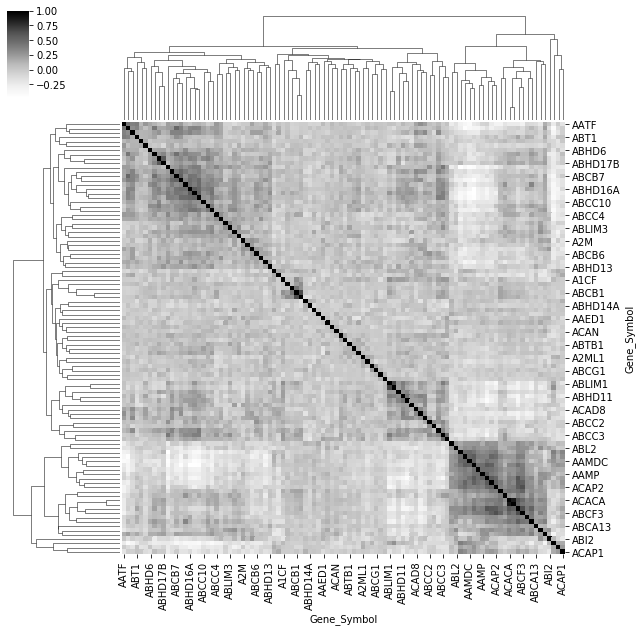

In [65]:
# ax = sns.clustermap(protein_similarity_matrix, figsize=(10,10), cmap="Greys")
ax = sns.clustermap(protein_similarity_matrix.iloc[:100, :100], figsize=(10,10), cmap="Greys")

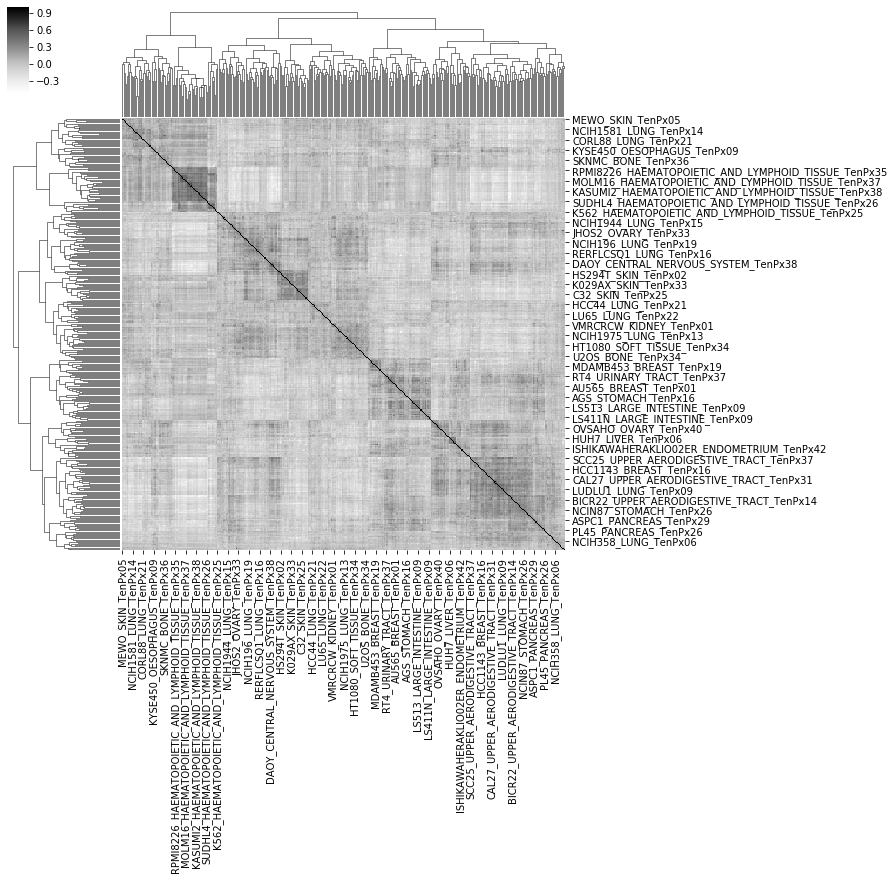

In [66]:
ax = sns.clustermap(attribute_similarity_matrix, figsize=(10,10), cmap="Greys")

## Save protein similarity matrix

In [67]:
save(protein_similarity_matrix, filepath, "proteomics_protein_similarity_matrix_{}.tsv".format(dataset_name))

SAVED! ./data/proteomics_protein_similarity_matrix_proteomicsdb.tsv


## Save attribute similarity matrix

In [68]:
save(attribute_similarity_matrix, filepath, "proteomics_attribute_similarity_matrix_{}.tsv".format(dataset_name))

SAVED! ./data/proteomics_attribute_similarity_matrix_proteomicsdb.tsv


## Create Gene List

In [69]:
if dataset_name == "proteomicsdb":
    gene_list = protein_id_df[["GeneSym", "Uniprot_Acc"]]
    gene_list.columns = ["GeneSym", "GeneID"]
    save(gene_list, filepath, "proteomics_gene_list_{}.tsv".format(dataset_name))

SAVED! ./data/proteomics_gene_list_proteomicsdb.tsv


## Create Attribute List

In [70]:
attribute_list = pd.DataFrame(protein_expression_df_filtered.columns)
attribute_list.columns = ["Attributes"]

In [71]:
attribute_list

,Attributes
0,MDAMB468_BREAST_TenPx01
1,SH4_SKIN_TenPx01
2,AU565_BREAST_TenPx01
3,KMRC1_KIDNEY_TenPx01
4,CAL51_BREAST_TenPx01
...,...
373,FADU_UPPER_AERODIGESTIVE_TRACT_TenPx24
374,KP4_PANCREAS_TenPx24
375,MONOMAC6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE_Te...
376,OVCAR8_OVARY_TenPx24


## Save Attribute List

In [72]:
save(attribute_list, filepath, "proteomics_attribute_list_{}.tsv".format(dataset_name))

SAVED! ./data/proteomics_attribute_list_proteomicsdb.tsv


## Create Gene-Attribute Edge List

In [73]:
def createGeneAttributeEdgeList(inputDF, attributelist):

    count = 0

    col = ["GeneSym"]
    col.insert(2, 'Attribute')
    col.append('Weight')
    print(col)
    temp = pd.DataFrame(columns=col)
    col = ['{0}\t'.format(elem) for elem in col]
    col.insert(len(col), '\n')

    result = []
    for i,col in enumerate(inputDF.columns):

        progressPercent = ((i+1)/len(inputDF.columns))*100

        clear_output(wait=True)
        display("Progress: %d%%  %d Out of %d" % (progressPercent, (i+1), len(inputDF.columns)))


        temp['GeneSym'] = inputDF[col].index
        temp['Attribute'] = [col]*len(temp['GeneSym'])
        temp['Weight'] = inputDF[col].values.tolist()

        count += temp[temp['Weight'] >= 0.95].shape[0]
        count += temp[temp['Weight'] <= -0.95].shape[0]

        for index in temp.index:
            lst = [temp.loc[index, 'Attribute'], temp.loc[index, 'GeneSym'], temp.loc[index, 'Weight']]
            result.append(lst)
    print('\n\n The number of statisticaly relevent gene-attribute associations is: %d' %count)
    return result


In [74]:
gene_attribute_edge_list = createGeneAttributeEdgeList(standard_matrix, attribute_list)

'Progress: 100%  378 Out of 378'



 The number of statisticaly relevent gene-attribute associations is: 228018


In [75]:
gene_attribute_edge_df = pd.DataFrame(gene_attribute_edge_list)
gene_attribute_edge_df.columns = ["CellLine", "GeneSym", "Weight"]

In [76]:
save(gene_attribute_edge_df, filepath, "proteomics_gene_attribute_edge_list_{}.tsv".format(dataset_name))

SAVED! ./data/proteomics_gene_attribute_edge_list_proteomicsdb.tsv
